<a href="https://colab.research.google.com/github/melvinwevers/audio_analysis/blob/main/2-speech-to-text.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Automatic Speech Recognition and Diarization

This notebook relies on Hugging Face for automatic speech recognition. For Diarization, we use a combination of Hugging Face and PyAnnote. The notebook uses OpenAI's Whisper model.

## Installing prerequisites
This can take a little while....

In [41]:
!pip install --upgrade pip -q
!pip install --upgrade git+https://github.com/huggingface/transformers.git accelerate datasets[audio] -q
!pip install evaluate jiwer -q
!pip install --upgrade pyannote.audio -q
print('-----------')
print('I\'m ready')

  Installing build dependencies ... done
  Getting requirements to build wheel ... canceled
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 180, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/req_command.py", line 245, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 377, in run
    requirement_set = resolver.resolve(
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/resolution/resolvelib/resolver.py", line 76, in resolve
    collected = self.factory.collect_root_requirements(root_reqs)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/resolution/resolvelib/factory.py", line 534, in collect_root_requirements
    reqs = list(
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/resolution/resolvelib/factory.py", line 490, i

In [2]:
!git clone https://github.com/melvinwevers/audio_analysis.git
%cd audio_analysis/data

Cloning into 'audio_analysis'...
remote: Enumerating objects: 63, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 63 (delta 3), reused 4 (delta 0), pack-reused 50
Receiving objects: 100% (63/63), 57.06 MiB | 23.46 MiB/s, done.
Resolving deltas: 100% (3/3), done.
/content/audio_analysis


In [5]:
%ls

liederenbank/  vvb/


In [37]:
from IPython.display import Audio as playaudio
from IPython.display import HTML, display
from pathlib import Path
import pandas as pd
import torch
import locale
from evaluate import load
from transformers import AutoModelForSpeechSeq2Seq, AutoProcessor, pipeline
from datasets import Audio, load_dataset, Dataset
from tqdm import tqdm
import google.colab
from transformers.pipelines.pt_utils import KeyDataset
from pyannote.audio import Pipeline
import torchaudio
from speechbox import ASRDiarizationPipeline

device = "cuda:0" if torch.cuda.is_available() else "cpu"
torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32


locale.getpreferredencoding = lambda: "UTF-8"

## Helper Functions

In [7]:
def set_css():
  '''
  this enables line wrapping in google colab output
  '''

  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)


def get_matching_audio_file_name(transcription_file_name):
  '''
  This function matches the file names of the audio files with those of the transcriptions.
  This is only needed for liederenbank
  '''
  # Split the name on underscore and take the first part
  return transcription_file_name.split('_')[0]

def tuple_to_string(start_end_tuple, ndigits=1):
    return str((round(start_end_tuple[0], ndigits), round(start_end_tuple[1], ndigits)))


def format_as_transcription(raw_segments):
  '''
  This prettifies the diarization output
  '''
  return "\n\n".join(
      [
          chunk["speaker"] + " " + tuple_to_string(chunk["timestamp"]) + chunk["text"]
          for chunk in raw_segments
      ]
  )

## Prepare dataset
Here we prepare our data in the correct `Datasets` format for Hugging Face to use it

### Construct metadata file

You only have to do this once, but it's ok if you run it again.

In [8]:
project = 'vvb' # Options: 'liederenbank' or 'vvb'
folder_path = Path(f'{project}')

output_file = folder_path / 'metadata.csv'
if output_file.exists():
  print(f"'{output_file}' already exists. Skipping execution.")

else:
  audio_extension = '.mp3'  # Change to '.wav' if needed
  audio_files = {file.stem: file for file in folder_path.glob(f'data/*{audio_extension}')}

  transcription_files = folder_path.glob('data/*.txt')
  data = []

  for transcription_file in transcription_files:
        audio_file = audio_files.get(transcription_file.stem) if project != 'liederenbank' \
            else audio_files.get(get_matching_audio_file_name(transcription_file.stem))
        if audio_file:
          try:
              with transcription_file.open('r', encoding='latin-1') as file: # We use this encoding because files were made on Windows
                  print(f"Processing {transcription_file}")
                  transcription_content = file.read().strip()
              data.append({'file_name': str(audio_file.relative_to(folder_path)), 'transcription': transcription_content})
          except IOError as e:
              print(f"Error reading file {transcription_file}: {e}")

  if data:
      df = pd.DataFrame(data)
      with output_file.open('w', encoding='latin-1') as file:
          df.to_csv(file, index=False)
      print(f"Metadata written to '{output_file}'")
  else:
      print("No data to write.")


'vvb/metadata.csv' already exists. Skipping execution.


## Prepare dataset
We will use the metadata.csv to construct a dataset in the Hugging Face Dataset format.

In [9]:
 # folder_path is defined in previous cell.
dataset = load_dataset("audiofolder", data_dir=folder_path)

# we will change the sampling_rate from 44.1khz to 16khz
dataset = dataset.cast_column("audio", Audio(sampling_rate=16000))

Resolving data files:   0%|          | 0/21 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [10]:
# Here we will inspect the dataset.

print(dataset["train"][0])

{'audio': {'path': '/content/audio_analysis/data/vvb/data/VODA_004_19.mp3', 'array': array([ 7.27595761e-12,  2.91038305e-11, -3.63797881e-11, ...,
        4.63270311e-10,  6.16061868e-10,  5.94994276e-10]), 'sampling_rate': 16000}, 'transcription': 'Der was, war’ze an’t dorsen waren, op een plaats war’ze an’t dorsenen en toen kwam er ook zo’n vrouwke langs en toen zei die: “hoe goat het ermee? Hedde’t werk af, hedde’t werk af?” “ben de gek?” zei die boer zo, “as we ’t kaf maar hebben”. Moar ja niks is kaf en die hadden geen, geen rogge.'}


#### Exercises
1. What do we see in this dataset?
2. Show the fifth row in the test set?
3. What would be a reason to reduce the sampling rate to 16khz?

## Applying Whisper

### Load model
There are different models to chose from. We will now chose the largest (`large-v3`), which is faster than the v2 version. Smaller versions are faster but less accurate.

Options include:
- `tiny`
- `base`
- `small`
- `medium`
- `large`
- `large-v2`
- `large-v3`

In [12]:
model_id = "openai/whisper-large-v3" # change the part after `whisper-`

model = AutoModelForSpeechSeq2Seq.from_pretrained(
    model_id, torch_dtype=torch_dtype, low_cpu_mem_usage=True, use_safetensors=True,
)
model.to(device)

config.json:   0%|          | 0.00/1.98k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/290M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/3.81k [00:00<?, ?B/s]

WhisperForConditionalGeneration(
  (model): WhisperModel(
    (encoder): WhisperEncoder(
      (conv1): Conv1d(80, 512, kernel_size=(3,), stride=(1,), padding=(1,))
      (conv2): Conv1d(512, 512, kernel_size=(3,), stride=(2,), padding=(1,))
      (embed_positions): Embedding(1500, 512)
      (layers): ModuleList(
        (0-5): 6 x WhisperEncoderLayer(
          (self_attn): WhisperSdpaAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=False)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=512, out_features=2048, bias=True)
          (fc2): Linear(in_features=2048, out_features=512, bias=True)
          

## Load Processing Pipeline

In [13]:
processor = AutoProcessor.from_pretrained(model_id)

asr_pipeline = pipeline(
    "automatic-speech-recognition", # here we do ASR without translation,
    model=model,
    tokenizer=processor.tokenizer,
    feature_extractor=processor.feature_extractor,
    max_new_tokens=128,
    chunk_length_s=30,
    batch_size=16,
    return_timestamps=True, #this can also be set to False, if we don't want timestamps
    torch_dtype=torch_dtype,
    device=device,
)

preprocessor_config.json:   0%|          | 0.00/185k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/283k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/836k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.48M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/494k [00:00<?, ?B/s]

normalizer.json:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.19k [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


## Demo

In this demo, we will load a sample clip from our data set.

In [14]:

sample_nr = 0 # you can change this value to select a different sample

sample = dataset["train"][sample_nr]["audio"]
print(dataset["train"][sample_nr]["transcription"])
playaudio(sample["array"], rate=sample["sampling_rate"])

Der was, war’ze an’t dorsen waren, op een plaats war’ze an’t dorsenen en toen kwam er ook zo’n vrouwke langs en toen zei die: “hoe goat het ermee? Hedde’t werk af, hedde’t werk af?” “ben de gek?” zei die boer zo, “as we ’t kaf maar hebben”. Moar ja niks is kaf en die hadden geen, geen rogge.


### Running single sample through ASR pipeline

In [40]:
asr_pipeline(sample.copy(), generate_kwargs={"language": "dutch"})


{'text': ' Er was een toosse daar, er was een toosse. En dan waren we ook zo vrouwkelaas. Ze zitten hier hoe goud en meen en een veuk af. Bij een gijks in die bouwers. Als we het kraft meer hebben. Maar ja, niks is koud en ja, geen rocht.',
 'chunks': [{'timestamp': (0.0, 4.0),
   'text': ' Er was een toosse daar, er was een toosse.'},
  {'timestamp': (4.0, 6.0), 'text': ' En dan waren we ook zo vrouwkelaas.'},
  {'timestamp': (6.0, 9.0),
   'text': ' Ze zitten hier hoe goud en meen en een veuk af.'},
  {'timestamp': (9.0, 11.0), 'text': ' Bij een gijks in die bouwers.'},
  {'timestamp': (11.0, 12.0), 'text': ' Als we het kraft meer hebben.'},
  {'timestamp': (12.0, 14.0),
   'text': ' Maar ja, niks is koud en ja, geen rocht.'}]}

In [ ]:
# you can also point directly to an .mp3
asr_pipeline('data/vvb/data/VODA_004_19.mp3')

#### Exercises
1. Try changing the language and see what happens to the prediction
2. Upload your own file. Make sure it's not too long. Else use https://audiotrimmer.com/ to trim it
3. Experiment with different models. What do you notice?

## Running batch prediction

Here we apply the pipeline to the entire dataset.
We produce a list called `all_predictions`

In [ ]:
all_predictions = []
for prediction in tqdm(
    asr_pipeline(
        KeyDataset(dataset['train'], "audio")
    ),
    total=len(dataset['train']),
):
    all_predictions.append(prediction["text"])


### Exercises
1. How many predictions did we make?
2. What is the longest prediction in terms of text length?

## Evaluation

Here we will evaluate our predictions by comparing them to our transcriptions. We will use Word Error Rate as a metric.

In [ ]:
from transformers.models.whisper.english_normalizer import BasicTextNormalizer
# this is a basic normalizer to remove punctuation and casing.

transcribed_texts = dataset['train']['transcription'] # we place all our transcriptions in a list.

normalizer = BasicTextNormalizer()
normalized_predictions = [normalizer(text) for text in all_predictions]
normalized_transcription = [normalizer(text) for text in transcribed_texts]


In [ ]:
metric = load("wer")
print(100 * metric.compute(references=normalized_transcription, predictions=normalized_predictions))

### Exercises
1. What does Word Error Rate measure?
2. Is your result good or bad? Explain why
3. Does normalization improve or worsen results?

## Diarization

For this part, you need an account on Hugging Face.

Create an account on Hugging Face and then continue with the notebook.

In [16]:
from huggingface_hub import notebook_login

notebook_login()

# create a token and copy it here
# you might need to accept some licenses



In [17]:
# Here we load the diarization pipeline from PyAnnote. We load version 3.1, which requires the authentication token.

diarization_pipeline = Pipeline.from_pretrained(
    "pyannote/speaker-diarization-3.1", use_auth_token=True
)
diarization_pipeline.to(torch.device('cuda'))

config.yaml:   0%|          | 0.00/469 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/5.91M [00:00<?, ?B/s]

config.yaml:   0%|          | 0.00/399 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/26.6M [00:00<?, ?B/s]

config.yaml:   0%|          | 0.00/221 [00:00<?, ?B/s]

In [19]:
# upload a file using widget
audio_file = list(google.colab.files.upload())[0]



Saving 024d5aa371dfe53c99fb54b95adff632.mp3 to 024d5aa371dfe53c99fb54b95adff632.mp3


In [20]:
#audio_file = dataset["train"][0]["audio"] # or choose from file from created dataset before
audio_dataset = Dataset.from_dict({"audio": [audio_file]}).cast_column("audio", Audio())
result = asr_pipeline(audio_dataset[0]['audio'].copy(), generate_kwargs={"language": "dutch"})
print(result)

{'text': ' Ik had me erover, ik had er wel wijkers door de prood nog heren, zo gait mij ook wel in mijn baaren en prood nog heren. En toen kom ik tegen de verglotere aan en dan was ik schuiten om ze er echt, beschweeld voor gruiden. Ik had vandaag wat gezien, dat was heel de familie van mijn hele leven niet. Ik had er ook wel zeggen dat mijn baardijn aan de zin is. Ja, dat was er ongeveer een tijd om te zijn. Ja, dat was er ongeveer een tijd om te zijn. Ja, dat was er ongeveer een tijd om te zijn. Ja, dat was er ongeveer een tijd om te zijn. Ja, dat was er ongeveer een tijd om te zijn. Ja, dat was er ongeveer een tijd om te zijn. Ja, dat was er ongeveer een tijd om te zijn. Ja, dat was er ongeveer Dat was de laatste. Ja, maar nu was het nog wel een week. Oh, dat was de laatste. Oh, dat was de laatste. Oh, een welk. Dat was de laatste. Ja, en laat het nog wel in de schrepen. En schrepen het nog wel in de laatste. En schrepen het nog wel in de laatste.', 'chunks': [{'timestamp': (0.0, 4.

In [23]:
waveform, sample_rate = torchaudio.load(audio_file) #preloading in memory for faster processing
audio_file = {"waveform": waveform, "sample_rate": sample_rate}


diarization = diarization_pipeline(audio_file, min_speakers=2, max_speakers=2)
diarization = diarization.rename_labels({"SPEAKER_00": "Guest", "SPEAKER_01": "Host"})

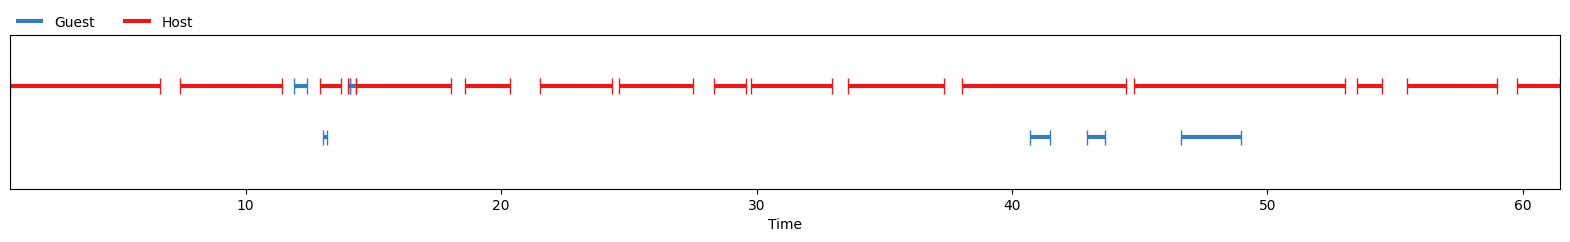

In [24]:
diarization

In [25]:

for turn, _, speaker in diarization.itertracks(yield_label=True):
    print(f"start={turn.start:.1f}s stop={turn.end:.1f}s speaker_{speaker}")

start=0.8s stop=6.6s speaker_Host
start=7.4s stop=11.4s speaker_Host
start=11.9s stop=12.4s speaker_Guest
start=12.9s stop=13.7s speaker_Host
start=13.0s stop=13.2s speaker_Guest
start=14.0s stop=14.1s speaker_Host
start=14.1s stop=14.3s speaker_Guest
start=14.3s stop=18.1s speaker_Host
start=18.6s stop=20.4s speaker_Host
start=21.5s stop=24.4s speaker_Host
start=24.6s stop=27.5s speaker_Host
start=28.3s stop=29.6s speaker_Host
start=29.8s stop=33.0s speaker_Host
start=33.6s stop=37.3s speaker_Host
start=38.1s stop=44.5s speaker_Host
start=40.7s stop=41.5s speaker_Guest
start=42.9s stop=43.6s speaker_Guest
start=44.8s stop=53.0s speaker_Host
start=46.6s stop=49.0s speaker_Guest
start=53.5s stop=54.5s speaker_Host
start=55.5s stop=59.0s speaker_Host
start=59.8s stop=61.5s speaker_Host


In [26]:
total_speaking_time = {}


for turn, _, speaker in diarization.itertracks(yield_label=True):
    # Calculate the duration of the current speaking turn
    duration = turn.end - turn.start

    # If the speaker is already in the dictionary, add the duration to their total time
    if speaker in total_speaking_time:
        total_speaking_time[speaker] += duration
    else:
        # If the speaker is not in the dictionary, add them with the current duration as their total time
        total_speaking_time[speaker] = duration

In [27]:
total_speaking_time

{'Host': 51.069609507640074, 'Guest': 4.702886247877757}

#### Exercises

1. Find an audio file with multiple people speaking. For example, a podcast, or a political debate.
2. Then trim the file using: https://audiotrimmer.com/ to speed up the analysis.
3. Run through the diarization. What is the total speaking time of the speakers.
4. What is the mean speaking time of each speaker?